# Load Model

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("chatglm3-6b", trust_remote_code=True)
model = AutoModel.from_pretrained("chatglm3-6b", trust_remote_code=True).half().cuda()
print(model)

# 处理数据集

In [1]:
import pandas as pd
import numpy as np
import datasets

# 数据加载1：leetcodesolutions_en_2k
data1 = pd.read_parquet('leetcodesolutions_en_2k/data/train-00000-of-00001-cac5db6da43d45a6.parquet')
data1.head()

,instruction,input,output
0,"Use c++ to solve the following problems, and g...",Given an array of integers `nums` and an integ...,```cpp\n#include <vector>\n#include <unordered...
1,"Use java to solve the following problems, and ...",Given an array of integers `nums` and an integ...,```java\nimport java.util.HashMap;\nimport jav...
2,"Use python to solve the following problems, an...",Given an array of integers `nums` and an integ...,"```python\ndef twoSum(nums, target):\n map ..."
3,Use javascript to solve the following problems...,Given an array of integers `nums` and an integ...,"```javascript\nfunction twoSum(nums, target) {..."
4,"Use c++ to solve the following problems, and g...",You are given two **non-empty** linked lists r...,```cpp\nstruct ListNode {\n int val;\n L...


In [2]:
# 数据加载2：acwingSolutions_1k
data2=pd.read_parquet('acwingSolutions_1k/data/acwingSolutions_1k.parquet')
data2.head()

,name,problem,solution
0,01串,给定一个仅包含 $0$ 或 $1$ 的字符串，现在可以对其进行一种操作：\n当有两个相邻的字...,```cpp\n#include<bits/stdc++.h>\nusing namespa...
1,01背包问题,有 $N$ 件物品和一个容量是 $V$ 的背包。每件物品只能使用一次。\n第 $i$ 件物品...,```cpp\n#include<bits/stdc++.h>\nusing namespa...
2,0到n-1中缺失的数字,一个长度为 $n-1$ 的递增排序数组中的所有数字都是唯一的，并且每个数字都在范围 $0$ ...,```cpp\nclass Solution {\npublic:\n int get...
3,1 的个数,给定一个数字 $N$，请你计算 $1 \sim N$ 中一共出现了多少个数字 $1$。\n例...,```cpp\n#include <iostream>\n#include <vector>...
4,2^k进制数,设 $r$ 是个 $2^k$ 进制数，并满足以下条件：\n\n$r$ 至少是个 $2$ 位的...,```cpp\n#include <bits/stdc++.h>\nusing namesp...


In [3]:
# 数据加载3：code_contests
data3=pd.read_parquet('code_contests/data/train-00000-of-00039-e991a271dbfa9925.parquet')
data3['solutions'][0]['solution']

array(["for _ in range(input()):\n    try:\n        eval(raw_input())\n        print 'YES'\n    except TypeError:\n        print 'YES'\n    except:\n        print 'NO'",
       'for _ in range(input()):\n    ins = raw_input().strip()\n    stck = []\n    res = "YES"\n    for x in ins:\n        if x == "(":\n            stck.append(x)\n        else:\n            if len(stck)>0:\n                stck.pop()\n            else:\n                res = "NO"\n                break\n    if len(stck) > 0: res = "NO" \n    print res',
       "for _ in range(input()):\n    try: eval(raw_input()); print 'YES'\n    except TypeError: print 'YES'\n    except: print 'NO'"],
      dtype=object)

In [4]:

def build_inputs(query, history):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response)
    prompt += "[Round {}]\n\n问：{} -> \n\n答：".format(len(history) + 1, query)
    return prompt 
his=[]
print(build_inputs('味道不太行',history=his))

[Round 1]

问：味道不太行 -> 

答：


In [5]:
data1['context'] = [build_inputs(row['instruction']+row['input'],history=his) for index,row in data1.iterrows()]
data1['target'] = [x for x in data1['output']]

data2['context'] = [build_inputs(row['problem'],history=his) for index,row in data2.iterrows()]
data2['target'] = [x for x in data2['solution']]

data3['context'] = [build_inputs(row['description'],history=his) for index,row in data3.iterrows()]
data3['target'] = [x['solution'][0]  if len(x['solution'])>0 else "I don't know how to solve this problem." for x in data3['solutions']]

df=pd.DataFrame()
df =data1[['context','target']]
df = pd.concat([df,data2[['context','target']]])
df = pd.concat([df,data3[['context','target']]])
df.reset_index(drop=True,inplace=True)
df

,context,target
0,[Round 1]\n\n问：Use c++ to solve the following ...,```cpp\n#include <vector>\n#include <unordered...
1,[Round 1]\n\n问：Use java to solve the following...,```java\nimport java.util.HashMap;\nimport jav...
2,[Round 1]\n\n问：Use python to solve the followi...,"```python\ndef twoSum(nums, target):\n map ..."
3,[Round 1]\n\n问：Use javascript to solve the fol...,"```javascript\nfunction twoSum(nums, target) {..."
4,[Round 1]\n\n问：Use c++ to solve the following ...,```cpp\nstruct ListNode {\n int val;\n L...
...,...,...
3385,[Round 1]\n\n问：In the Land of Fire there are n...,#include <bits/stdc++.h>\nusing namespace std;...
3386,[Round 1]\n\n问：You are given a matrix consisti...,I don't know how to solve this problem.
3387,[Round 1]\n\n问：You are given a string s consis...,#include <bits/stdc++.h>\nusing namespace std;...
3388,[Round 1]\n\n问：A smile house is created to rai...,#include <bits/stdc++.h>\nusing namespace std;...


In [6]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df, test_size=0.2)

ds_train = datasets.Dataset.from_pandas(df_train)
ds_val = datasets.Dataset.from_pandas(df_test)

In [7]:
from tqdm import tqdm
import transformers

#token编码
model_name="chatglm3-6b"
max_seq_length=1000
skip_over_length=True


tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)

config = transformers.AutoConfig.from_pretrained(
    model_name, trust_remote_code=True, device_map='auto')

def preprocess(example):
    context=example["context"]
    target=example["target"]
    
    context_ids = tokenizer.encode(
        context, 
        max_length=max_seq_length,
        truncation=True)
    
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    
    input_ids = context_ids + target_ids + [config.eos_token_id]
    
    return {"input_ids": input_ids, "context_len": len(context_ids),'target_len':len(target_ids)}

ds_train_token = ds_train.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length:
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/2712 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2712 [00:00<?, ? examples/s]

Map:   0%|          | 0/678 [00:00<?, ? examples/s]

Filter:   0%|          | 0/678 [00:00<?, ? examples/s]

In [8]:
# 管道构建
import torch

def data_collator(features:list):
    len_ids = [len(feature["input_ids"]) for feature in features]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        ids = feature["input_ids"]
        context_len = feature["context_len"]
        
        labels = (
            [-100] * (context_len - 1) + ids[(context_len - 1) :] + [-100] * (longest - length)
        ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labels))
        
        
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=2,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=2,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)


for batch in dl_train:
    break 
    

dl_train.size = 300 


# 定义lora模型

In [9]:
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

model = AutoModel.from_pretrained("chatglm3-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True, 
                                  device_map='auto')

model.supports_gradient_checkpointing = True # 节约cuda
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)
model.is_parallelizable = True
model.model_parallel = True
model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


# 训练模型

<<<<<< ⚡️ cuda is used >>>>>>


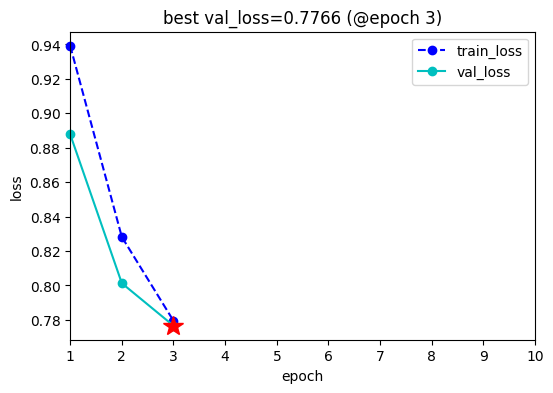

In [ ]:
from torchkeras import KerasModel
from accelerate import Accelerator

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
            
    def __call__(self, batch):
        
        # loss
        with self.accelerator.autocast():
            loss=self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss
        
        # backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
        
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner


# 仅保存lora可训练参数
def save_ckpt(self,ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint.pt'):
    self.net = self.net.from_pretrained(self.net, ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt


keras_model = KerasModel(model,loss_fn = None, optimizer=torch.optim.AdamW(model.parameters(), lr=2e-6))
ckpt_path = "CodeGLM"

keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs = 100,
                patience = 5,
                monitor = 'val_loss',
                mode = 'min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16'
               )

# 验证模型

In [ ]:
from peft import PeftModel
model = AutoModel.from_pretrained("chatglm3-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True, 
                                  device_map='auto')
model = PeftModel.from_pretrained(model,ckpt_path)
model = model.merge_and_unload() #合并lora权重

def predict(text,temperator=0.01):  # temperator设置的越大，输出的随机性就越大
    response, history = model.chat(tokenizer, f"{text} -> ", history=his,
    temperature=temperator)
    return response 
    
predict('Write a decision tree.')

# 保存模型

In [ ]:
model.save_pretrained("CodeGLM_model", max_shard_size='1GB')

tokenizer.save_pretrained("CodeGLM_model")